# Hard Veri Seti

In [11]:
import os
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import csv
import warnings
import pandas as pd

# Python uyarılarını kapatma
warnings.filterwarnings('ignore')

In [12]:
# Dosyanın var olup olmadığını kontrol edin ve varsa silin
data_csv='/kaggle/working/dataset.csv'
if os.path.exists(data_csv):
    os.remove(data_csv)
    print(f"{data_csv} dosyası silindi.")
else:
    print(f"{data_csv} dosyası bulunamadı.")

data_csv='/kaggle/working/dataset.csv'
data1_dir = '/kaggle/input/fake-vs-real-face-classification/train'
data2_dir = '/kaggle/input/fake-vs-real-face-classification/Validation'

data3_dir = '/kaggle/input/hardfakevsrealfaces'

# CSV dosyasının varlığını kontrol et

if os.path.exists(data_csv):
    print('exists')
else:
    data_dirs = [data3_dir]

    # Define the path for the CSV file
    csv_file = 'dataset.csv'
    data_csv = csv_file

    # Define the class mapping
    class_mapping = {
        'fake': 'Fake',
        'real': 'Real',
        'Fake': 'Fake',
        'Real': 'Real',
        'training_fake': 'Fake',
        'training_real': 'Real',
        '0': 'Real',
        '1': 'Fake'
    }

    # Open the CSV file in write mode
    with open(csv_file, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['image', 'label'])  # Write the header row

        # Iterate through the directories in the dataset directory
        for data_dir in data_dirs:
            for root, dirs, files in os.walk(data_dir):
                for file in files:
                    if file.endswith('.jpg') or file.endswith('.png'):  # Adjust file extensions as needed
                        # Get the image path
                        image_path = os.path.join(root, file)

                        # Extract the label from the parent folder name
                        label = os.path.basename(root)

                        # Apply the mapping to the label
                        mapped_label = class_mapping.get(label, label)

                        # Write the image path and mapped label to the CSV file
                        writer.writerow([image_path, mapped_label])
                        
    print(f"{csv_file} dosyası oluşturuldu.")

/kaggle/working/dataset.csv dosyası silindi.
dataset.csv dosyası oluşturuldu.


In [13]:
import pandas as pd
# CSV dosyasını oku
data = pd.read_csv(data_csv)

# Resim boyutları
height, width = 224, 224

# Etiketleri değiştirme ve one-hot encoding işlemleri
def changeLabels(x):
    return labels[x]

labels = data.label.unique()
labels = {labels[i]: i for i in range(labels.size)}
y = data.label.apply(changeLabels)
y = to_categorical(y, len(labels))


# Resimleri yükleme ve işleme
X = np.empty((data.shape[0], height, width, 3), dtype=np.float32)  # Veri tipini float32 olarak ayarladık
for i in range(data.shape[0]):
    img_path = data.iloc[i]['image']  # Dosya yolunu al
    img = load_img(img_path, target_size=(height, width))  # Resmi yükle ve boyutlandır
    img_array = np.array(img) / 255.0  # Resmi numpy array'e çevir ve normalize et
    X[i] = img_array  # Array'i X'e ekle

print(X.shape)

(1289, 224, 224, 3)


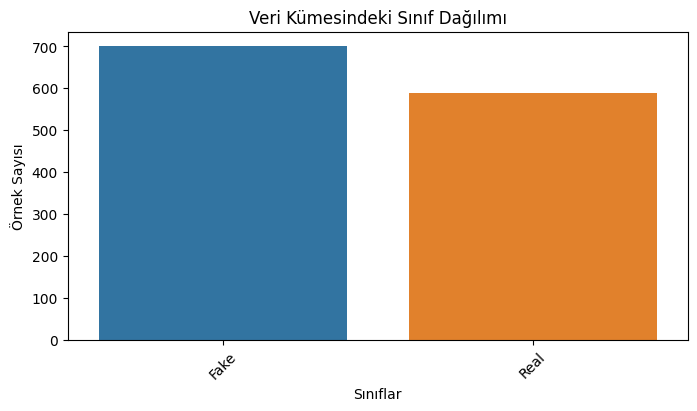

In [14]:
# Veri setindeki sınıf dağılımını görselleştirme
class_counts = data['label'].value_counts()
plt.figure(figsize=(8, 4))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.xlabel('Sınıflar')
plt.ylabel('Örnek Sayısı')
plt.title('Veri Kümesindeki Sınıf Dağılımı')
plt.xticks(rotation=45)
plt.show()


In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(902, 224, 224, 3)
(193, 224, 224, 3)
(194, 224, 224, 3)


In [16]:
# DenseNet121 modelini yükleme
tf.keras.backend.clear_session()
densenet = DenseNet121(weights='imagenet', include_top=False, input_shape=(height, width, 3))

# Transfer learning: DenseNet121 modelinin üstüne yeni katmanlar ekleyerek özelleştirme
x = Flatten()(densenet.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.45)(x)
output = Dense(len(labels), activation='softmax')(x)

# Yeni modeli oluşturma
model_densenet = Model(densenet.input, output)

# Modeli derleme
model_densenet.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
epochs = 15



In [17]:
# Modelin eğitimi
history = model_densenet.fit(X_train, y_train, epochs=epochs, validation_data=(X_val, y_val))

Epoch 1/15


W0000 00:00:1717048570.637014     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7830 - loss: 18.9150   

W0000 00:00:1717048681.788097     123 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717048692.121875     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


29/29 ━━━━━━━━━━━━━━━━━━━━ 252s 5s/step - accuracy: 0.7866 - loss: 18.5286 - val_accuracy: 0.5648 - val_loss: 3270.0239
Epoch 2/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 323ms/step - accuracy: 0.9759 - loss: 0.1408 - val_accuracy: 0.7927 - val_loss: 45.7540
Epoch 3/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 328ms/step - accuracy: 0.9890 - loss: 0.0299 - val_accuracy: 0.9223 - val_loss: 2.9023
Epoch 4/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 328ms/step - accuracy: 1.0000 - loss: 0.0045 - val_accuracy: 0.9741 - val_loss: 0.3234
Epoch 5/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 321ms/step - accuracy: 1.0000 - loss: 0.0014 - val_accuracy: 0.9793 - val_loss: 0.1038
Epoch 6/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 318ms/step - accuracy: 1.0000 - loss: 6.4480e-04 - val_accuracy: 0.9896 - val_loss: 0.0290
Epoch 7/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 317ms/step - accuracy: 1.0000 - loss: 7.8674e-04 - val_accuracy: 1.0000 - val_loss: 0.0018
Epoch 8/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 317ms/step - accuracy: 1.0000 - loss: 4.5194e-04 - val_accu

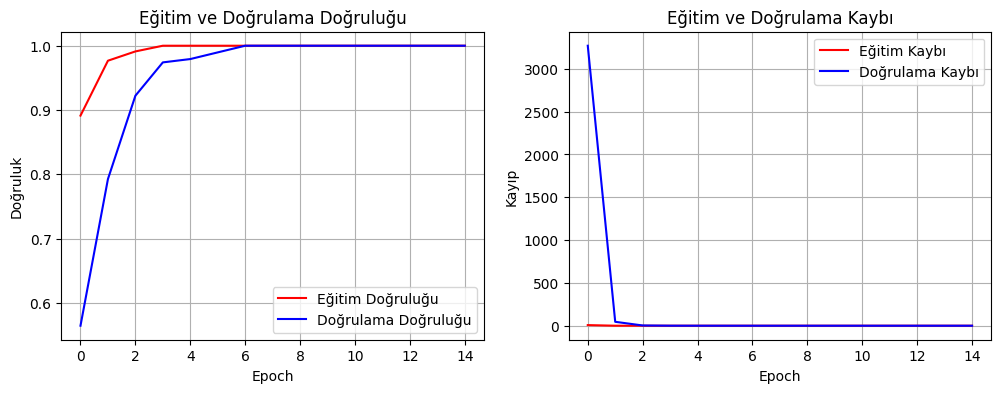

3/7 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step

W0000 00:00:1717048844.492738     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


7/7 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step


W0000 00:00:1717048853.214628     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


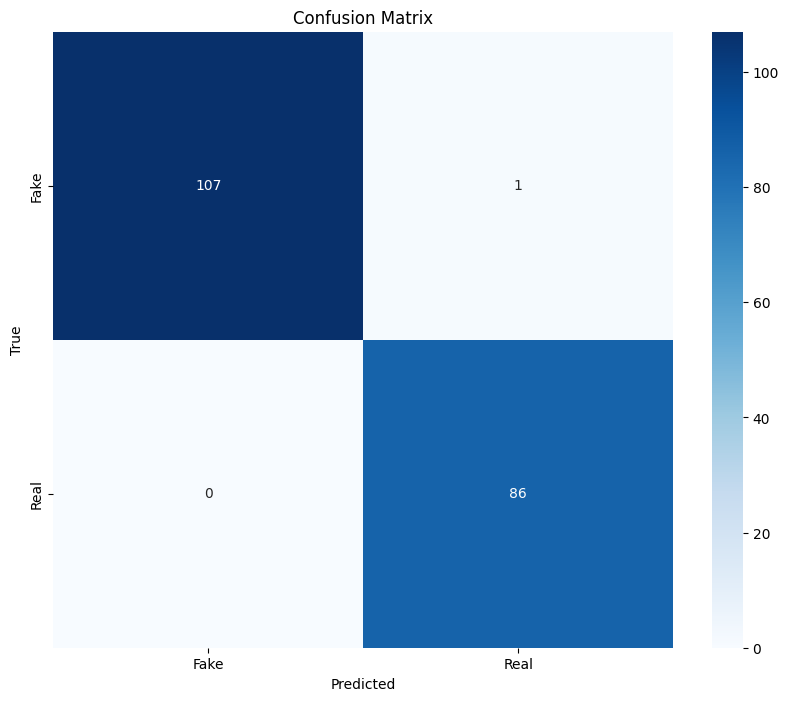

Precision: 0.9949
Recall: 0.9948
F1 Score: 0.9948
Test Accuracy: 0.9948


In [18]:
from sklearn.metrics import confusion_matrix

# Doğruluk ve kayıp grafiği
# Eğitim ve doğrulama doğruluğu ve kaybı grafikleri
plt.figure(figsize=(12, 4))

# Eğitim ve doğrulama doğruluğu
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu', color='red', linestyle='-')
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu', color='blue', linestyle='-')
plt.title('Eğitim ve Doğrulama Doğruluğu')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk')
plt.legend()
plt.grid(True)

# Eğitim ve doğrulama kaybı
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Eğitim Kaybı', color='red', linestyle='-')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı', color='blue', linestyle='-')
plt.title('Eğitim ve Doğrulama Kaybı')
plt.xlabel('Epoch')
plt.ylabel('Kayıp')
plt.legend()
plt.grid(True)

plt.show()

# Test verisi üzerinden confusion matrix grafiği
y_pred = model_densenet.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_true_labels, y_pred_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=labels.keys(), yticklabels=labels.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
# Test verisi üzerinde metrikleri hesaplama
precision = precision_score(y_true_labels, y_pred_labels, average='weighted')
recall = recall_score(y_true_labels, y_pred_labels, average='weighted')
f1 = f1_score(y_true_labels, y_pred_labels, average='weighted')
accuracy = accuracy_score(y_true_labels, y_pred_labels)

print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1 Score: {:.4f}".format(f1))
print("Test Accuracy: {:.4f}".format(accuracy))


# Easy Veri Seti

/kaggle/working/dataset.csv dosyası silindi.
dataset.csv dosyası oluşturuldu.
(1709, 224, 224, 3)


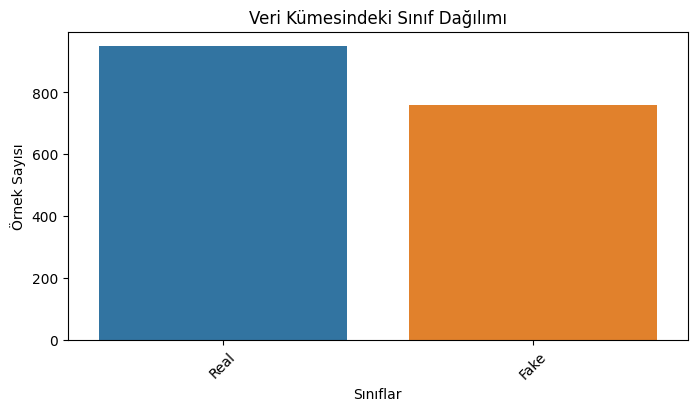

In [19]:
import os
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import csv
import warnings
import pandas as pd

# Python uyarılarını kapatma
warnings.filterwarnings('ignore')
# Dosyanın var olup olmadığını kontrol edin ve varsa silin
data_csv='/kaggle/working/dataset.csv'
if os.path.exists(data_csv):
    os.remove(data_csv)
    print(f"{data_csv} dosyası silindi.")
else:
    print(f"{data_csv} dosyası bulunamadı.")

data_csv='/kaggle/working/dataset.csv'
data1_dir = '/kaggle/input/fake-vs-real-face-classification/train'
data2_dir = '/kaggle/input/fake-vs-real-face-classification/Validation'

data3_dir = '/kaggle/input/hardfakevsrealfaces'

# CSV dosyasının varlığını kontrol et

if os.path.exists(data_csv):
    print('exists')
else:
    data_dirs = [data1_dir,data2_dir]

    # Define the path for the CSV file
    csv_file = 'dataset.csv'
    data_csv = csv_file

    # Define the class mapping
    class_mapping = {
        'fake': 'Fake',
        'real': 'Real',
        'Fake': 'Fake',
        'Real': 'Real',
        'training_fake': 'Fake',
        'training_real': 'Real',
        '0': 'Real',
        '1': 'Fake'
    }

    # Open the CSV file in write mode
    with open(csv_file, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['image', 'label'])  # Write the header row

        # Iterate through the directories in the dataset directory
        for data_dir in data_dirs:
            for root, dirs, files in os.walk(data_dir):
                for file in files:
                    if file.endswith('.jpg') or file.endswith('.png'):  # Adjust file extensions as needed
                        # Get the image path
                        image_path = os.path.join(root, file)

                        # Extract the label from the parent folder name
                        label = os.path.basename(root)

                        # Apply the mapping to the label
                        mapped_label = class_mapping.get(label, label)

                        # Write the image path and mapped label to the CSV file
                        writer.writerow([image_path, mapped_label])
                        
    print(f"{csv_file} dosyası oluşturuldu.")
    
import pandas as pd
# CSV dosyasını oku
data = pd.read_csv(data_csv)

# Resim boyutları
height, width = 224, 224

# Etiketleri değiştirme ve one-hot encoding işlemleri
def changeLabels(x):
    return labels[x]

labels = data.label.unique()
labels = {labels[i]: i for i in range(labels.size)}
y = data.label.apply(changeLabels)
y = to_categorical(y, len(labels))


# Resimleri yükleme ve işleme
X = np.empty((data.shape[0], height, width, 3), dtype=np.float32)  # Veri tipini float32 olarak ayarladık
for i in range(data.shape[0]):
    img_path = data.iloc[i]['image']  # Dosya yolunu al
    img = load_img(img_path, target_size=(height, width))  # Resmi yükle ve boyutlandır
    img_array = np.array(img) / 255.0  # Resmi numpy array'e çevir ve normalize et
    X[i] = img_array  # Array'i X'e ekle

print(X.shape)

# Veri setindeki sınıf dağılımını görselleştirme
class_counts = data['label'].value_counts()
plt.figure(figsize=(8, 4))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.xlabel('Sınıflar')
plt.ylabel('Örnek Sayısı')
plt.title('Veri Kümesindeki Sınıf Dağılımı')
plt.xticks(rotation=45)
plt.show()


In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(1196, 224, 224, 3)
(256, 224, 224, 3)
(257, 224, 224, 3)


In [21]:
# DenseNet121 modelini yükleme
tf.keras.backend.clear_session()
densenet = DenseNet121(weights='imagenet', include_top=False, input_shape=(height, width, 3))

# Transfer learning: DenseNet121 modelinin üstüne yeni katmanlar ekleyerek özelleştirme
x = Flatten()(densenet.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.45)(x)
output = Dense(len(labels), activation='softmax')(x)

# Yeni modeli oluşturma
model_densenet = Model(densenet.input, output)

# Modeli derleme
model_densenet.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])




In [22]:
from tensorflow.keras.callbacks import EarlyStopping
epochs = 30
# EarlyStopping callback
early_stopping_monitor = EarlyStopping(monitor='val_accuracy', patience=6,restore_best_weights=True  )
# Modelin eğitimi
history = model_densenet.fit(
    X_train, y_train, 
    epochs=epochs, 
    validation_data=(X_val, y_val),
    callbacks=early_stopping_monitor
)

Epoch 1/30


W0000 00:00:1717049005.129249     122 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5123 - loss: 15.9457   

W0000 00:00:1717049114.809336     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717049124.917739     122 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


38/38 ━━━━━━━━━━━━━━━━━━━━ 243s 3s/step - accuracy: 0.5122 - loss: 15.7695 - val_accuracy: 0.4492 - val_loss: 5441.4443
Epoch 2/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 13s 330ms/step - accuracy: 0.5228 - loss: 1.4192 - val_accuracy: 0.5508 - val_loss: 23.0774
Epoch 3/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 13s 335ms/step - accuracy: 0.5860 - loss: 0.6854 - val_accuracy: 0.5586 - val_loss: 11.5017
Epoch 4/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 12s 328ms/step - accuracy: 0.5274 - loss: 0.6876 - val_accuracy: 0.5508 - val_loss: 8.0555
Epoch 5/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 12s 321ms/step - accuracy: 0.5722 - loss: 0.6867 - val_accuracy: 0.5352 - val_loss: 2.0869
Epoch 6/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 12s 319ms/step - accuracy: 0.5619 - loss: 0.6764 - val_accuracy: 0.5508 - val_loss: 0.6901
Epoch 7/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 20s 317ms/step - accuracy: 0.5614 - loss: 0.6789 - val_accuracy: 0.5508 - val_loss: 0.7300
Epoch 8/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 12s 322ms/step - accuracy: 0.5732 - loss: 0.6637 - val_accuracy: 0

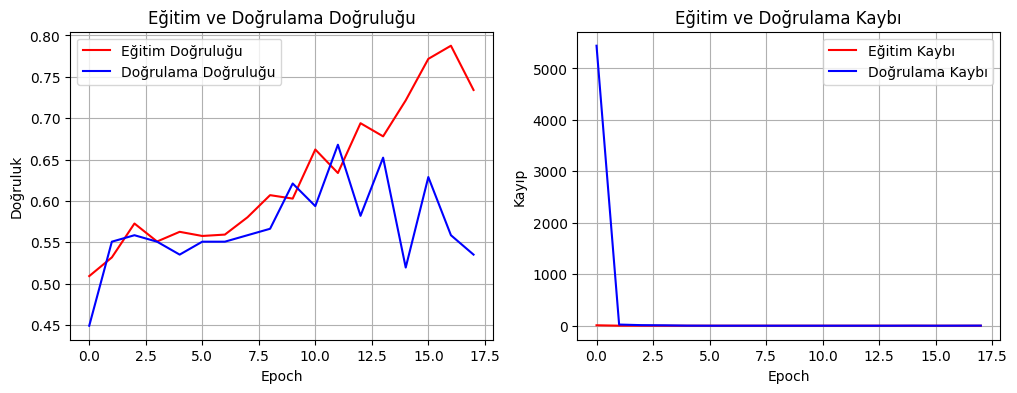

3/9 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step

W0000 00:00:1717049419.147755     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


9/9 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step


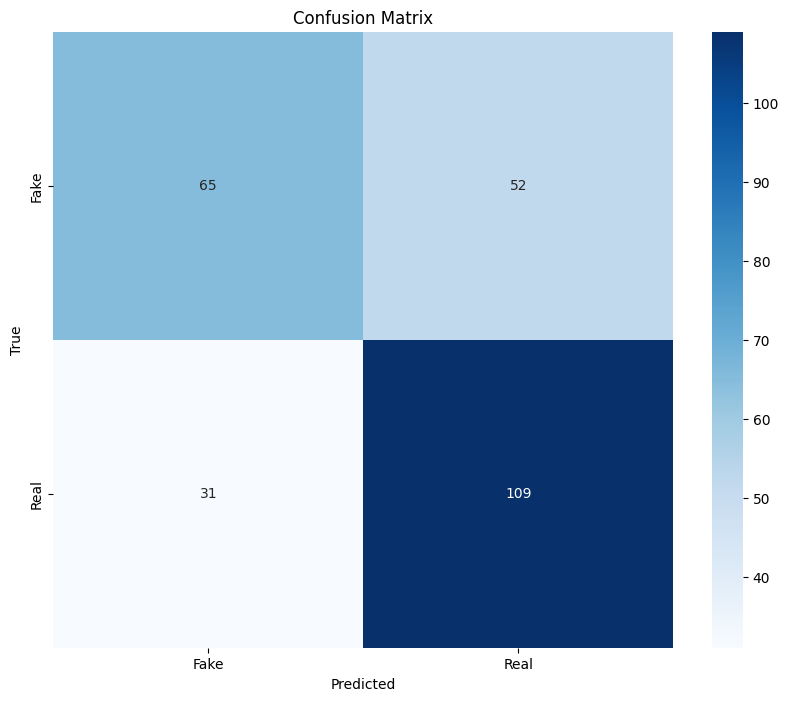

Precision: 0.6770
Recall: 0.6770
F1 Score: 0.6724
Test Accuracy: 0.6770


In [23]:
from sklearn.metrics import confusion_matrix

# Doğruluk ve kayıp grafiği
# Eğitim ve doğrulama doğruluğu ve kaybı grafikleri
plt.figure(figsize=(12, 4))

# Eğitim ve doğrulama doğruluğu
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu', color='red', linestyle='-')
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu', color='blue', linestyle='-')
plt.title('Eğitim ve Doğrulama Doğruluğu')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk')
plt.legend()
plt.grid(True)

# Eğitim ve doğrulama kaybı
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Eğitim Kaybı', color='red', linestyle='-')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı', color='blue', linestyle='-')
plt.title('Eğitim ve Doğrulama Kaybı')
plt.xlabel('Epoch')
plt.ylabel('Kayıp')
plt.legend()
plt.grid(True)

plt.show()

# Test verisi üzerinden confusion matrix grafiği
y_pred = model_densenet.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_true_labels, y_pred_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=labels.keys(), yticklabels=labels.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
# Test verisi üzerinde metrikleri hesaplama
precision = precision_score(y_true_labels, y_pred_labels, average='weighted')
recall = recall_score(y_true_labels, y_pred_labels, average='weighted')
f1 = f1_score(y_true_labels, y_pred_labels, average='weighted')
accuracy = accuracy_score(y_true_labels, y_pred_labels)

print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1 Score: {:.4f}".format(f1))
print("Test Accuracy: {:.4f}".format(accuracy))


# Veri Setlerinin Karıştırılması

/kaggle/working/dataset.csv dosyası silindi.
dataset.csv dosyası oluşturuldu.
(2998, 224, 224, 3)


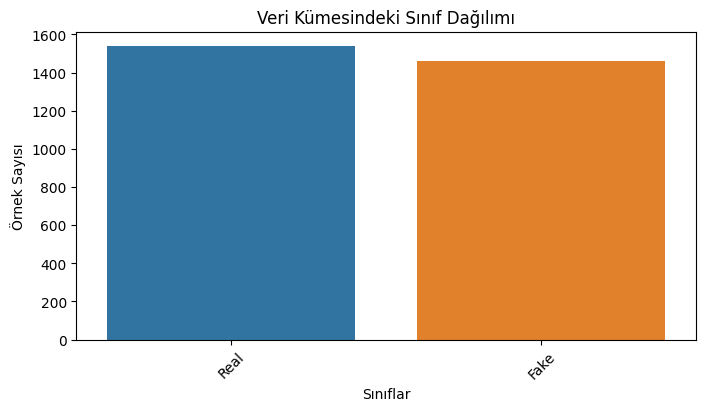

In [24]:
import os
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import csv
import warnings
import pandas as pd

# Python uyarılarını kapatma
warnings.filterwarnings('ignore')

# Dosyanın var olup olmadığını kontrol edin ve varsa silin
data_csv='/kaggle/working/dataset.csv'
if os.path.exists(data_csv):
    os.remove(data_csv)
    print(f"{data_csv} dosyası silindi.")
else:
    print(f"{data_csv} dosyası bulunamadı.")

data_csv='/kaggle/working/dataset.csv'
data1_dir = '/kaggle/input/fake-vs-real-face-classification/train'
data2_dir = '/kaggle/input/fake-vs-real-face-classification/Validation'

data3_dir = '/kaggle/input/hardfakevsrealfaces'

# CSV dosyasının varlığını kontrol et

if os.path.exists(data_csv):
    print('exists')
else:
    data_dirs = [data1_dir,data2_dir,data3_dir]

    # Define the path for the CSV file
    csv_file = 'dataset.csv'
    data_csv = csv_file

    # Define the class mapping
    class_mapping = {
        'fake': 'Fake',
        'real': 'Real',
        'Fake': 'Fake',
        'Real': 'Real',
        'training_fake': 'Fake',
        'training_real': 'Real',
        '0': 'Real',
        '1': 'Fake'
    }

    # Open the CSV file in write mode
    with open(csv_file, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['image', 'label'])  # Write the header row

        # Iterate through the directories in the dataset directory
        for data_dir in data_dirs:
            for root, dirs, files in os.walk(data_dir):
                for file in files:
                    if file.endswith('.jpg') or file.endswith('.png'):  # Adjust file extensions as needed
                        # Get the image path
                        image_path = os.path.join(root, file)

                        # Extract the label from the parent folder name
                        label = os.path.basename(root)

                        # Apply the mapping to the label
                        mapped_label = class_mapping.get(label, label)

                        # Write the image path and mapped label to the CSV file
                        writer.writerow([image_path, mapped_label])
                        
    print(f"{csv_file} dosyası oluşturuldu.")
    
    
import pandas as pd
# CSV dosyasını oku
data = pd.read_csv(data_csv)

# Resim boyutları
height, width = 224, 224

# Etiketleri değiştirme ve one-hot encoding işlemleri
def changeLabels(x):
    return labels[x]

labels = data.label.unique()
labels = {labels[i]: i for i in range(labels.size)}
y = data.label.apply(changeLabels)
y = to_categorical(y, len(labels))


# Resimleri yükleme ve işleme
X = np.empty((data.shape[0], height, width, 3), dtype=np.float32)  # Veri tipini float32 olarak ayarladık
for i in range(data.shape[0]):
    img_path = data.iloc[i]['image']  # Dosya yolunu al
    img = load_img(img_path, target_size=(height, width))  # Resmi yükle ve boyutlandır
    img_array = np.array(img) / 255.0  # Resmi numpy array'e çevir ve normalize et
    X[i] = img_array  # Array'i X'e ekle

print(X.shape)

# Veri setindeki sınıf dağılımını görselleştirme
class_counts = data['label'].value_counts()
plt.figure(figsize=(8, 4))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.xlabel('Sınıflar')
plt.ylabel('Örnek Sayısı')
plt.title('Veri Kümesindeki Sınıf Dağılımı')
plt.xticks(rotation=45)
plt.show()


In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(2098, 224, 224, 3)
(450, 224, 224, 3)
(450, 224, 224, 3)


In [26]:
# DenseNet121 modelini yükleme
tf.keras.backend.clear_session()
densenet = DenseNet121(weights='imagenet', include_top=False, input_shape=(height, width, 3))

# Transfer learning: DenseNet121 modelinin üstüne yeni katmanlar ekleyerek özelleştirme
x = Flatten()(densenet.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.45)(x)
output = Dense(len(labels), activation='softmax')(x)

# Yeni modeli oluşturma
model_densenet = Model(densenet.input, output)

# Modeli derleme
model_densenet.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])




In [27]:
from tensorflow.keras.callbacks import EarlyStopping
epochs = 30
# EarlyStopping callback
early_stopping_monitor = EarlyStopping(monitor='val_accuracy', patience=6,restore_best_weights=True  )
# Modelin eğitimi
history = model_densenet.fit(
    X_train, y_train, 
    epochs=epochs, 
    validation_data=(X_val, y_val),
    callbacks=early_stopping_monitor
)

Epoch 1/30


W0000 00:00:1717049610.461734     123 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5644 - loss: 14.3866   

W0000 00:00:1717049732.007436     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717049741.177132     123 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717049748.099555     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


66/66 ━━━━━━━━━━━━━━━━━━━━ 258s 2s/step - accuracy: 0.5645 - loss: 14.2739 - val_accuracy: 0.5400 - val_loss: 8002.8462
Epoch 2/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 22s 330ms/step - accuracy: 0.6370 - loss: 1.1070 - val_accuracy: 0.5667 - val_loss: 0.6743
Epoch 3/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 22s 331ms/step - accuracy: 0.7134 - loss: 0.5640 - val_accuracy: 0.7267 - val_loss: 0.5487
Epoch 4/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 21s 325ms/step - accuracy: 0.7294 - loss: 0.5176 - val_accuracy: 0.7978 - val_loss: 0.4191
Epoch 5/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 21s 321ms/step - accuracy: 0.7878 - loss: 0.4370 - val_accuracy: 0.7956 - val_loss: 0.4104
Epoch 6/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 21s 324ms/step - accuracy: 0.8033 - loss: 0.4141 - val_accuracy: 0.7889 - val_loss: 0.4022
Epoch 7/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 21s 323ms/step - accuracy: 0.8137 - loss: 0.4027 - val_accuracy: 0.7778 - val_loss: 0.4999
Epoch 8/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 22s 326ms/step - accuracy: 0.8020 - loss: 0.4116 - val_accuracy: 0.8

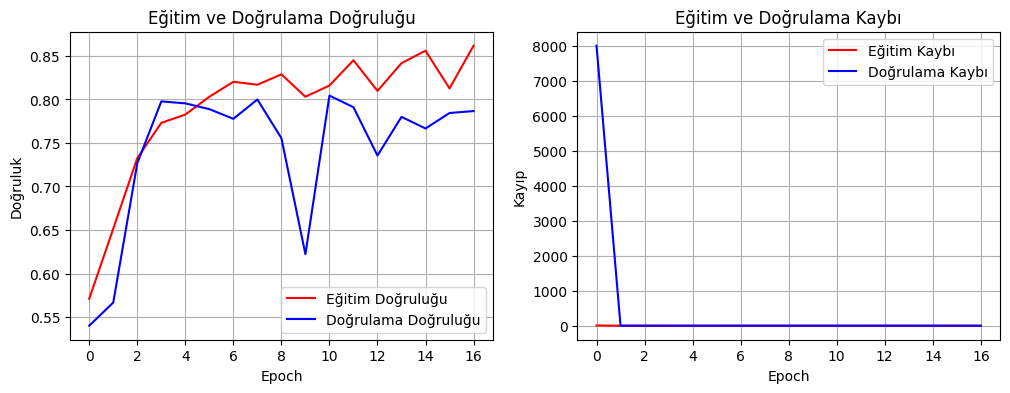

 3/15 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step

W0000 00:00:1717050102.739498     123 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


15/15 ━━━━━━━━━━━━━━━━━━━━ 18s 673ms/step


W0000 00:00:1717050112.162970     123 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


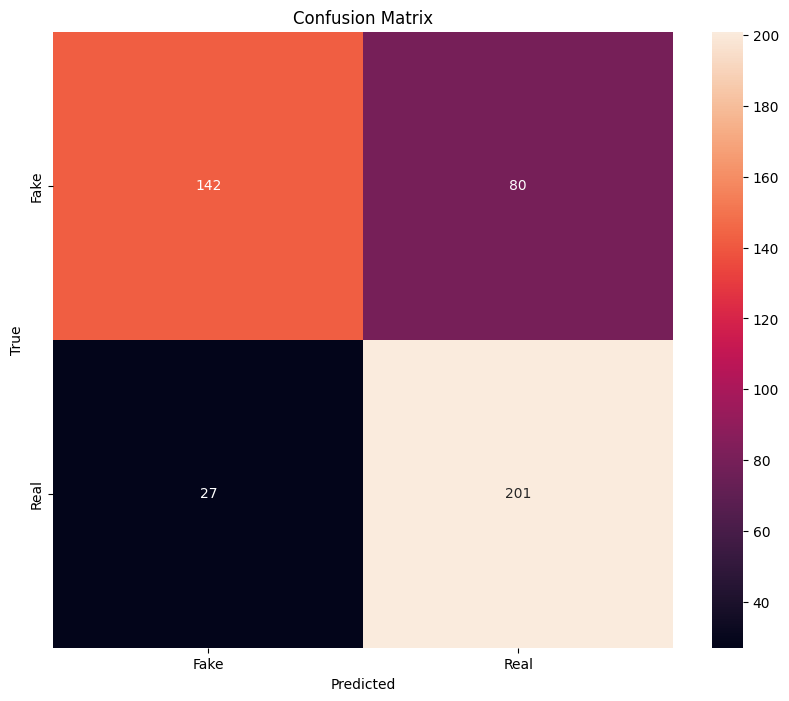

Precision: 0.7769
Recall: 0.7622
F1 Score: 0.7585
Test Accuracy: 0.7622


In [28]:
from sklearn.metrics import confusion_matrix

# Doğruluk ve kayıp grafiği
# Eğitim ve doğrulama doğruluğu ve kaybı grafikleri
plt.figure(figsize=(12, 4))

# Eğitim ve doğrulama doğruluğu
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu', color='red', linestyle='-')
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu', color='blue', linestyle='-')
plt.title('Eğitim ve Doğrulama Doğruluğu')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk')
plt.legend()
plt.grid(True)

# Eğitim ve doğrulama kaybı
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Eğitim Kaybı', color='red', linestyle='-')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı', color='blue', linestyle='-')
plt.title('Eğitim ve Doğrulama Kaybı')
plt.xlabel('Epoch')
plt.ylabel('Kayıp')
plt.legend()
plt.grid(True)

plt.show()

# Test verisi üzerinden confusion matrix grafiği
y_pred = model_densenet.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_true_labels, y_pred_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='g', xticklabels=labels.keys(), yticklabels=labels.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
# Test verisi üzerinde metrikleri hesaplama
precision = precision_score(y_true_labels, y_pred_labels, average='weighted')
recall = recall_score(y_true_labels, y_pred_labels, average='weighted')
f1 = f1_score(y_true_labels, y_pred_labels, average='weighted')
accuracy = accuracy_score(y_true_labels, y_pred_labels)

print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1 Score: {:.4f}".format(f1))
print("Test Accuracy: {:.4f}".format(accuracy))
